# Making Predictions On A Single Image

In [1]:
import torch
import torchvision
import os
import cv2
import numpy as np
from torch import nn
from glob import glob
import timm
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
device='cpu'

In [3]:
image_paths = './images/*/*/*'
image_paths = glob(image_paths)

In [4]:
image_paths

['./images/fundus/cataract/cropped_image_1153-jpg_jpg.rf.352496f63ac7a0f73800bbbeb753493c.jpg',
 './images/fundus/cataract/cropped_image_3003-jpg_jpg.rf.a716a3e5690c02123e8c7d42d804dfd2.jpg',
 './images/fundus/cataract/cropped_image_1174-jpg_jpg.rf.b66eb712f1a9f4496117c8ccae9b9d36.jpg',
 './images/fundus/cataract/cropped_image_5024-jpg_jpg.rf.70976edb26141c0d2ea4b98958f69308.jpg',
 './images/fundus/cataract/cropped_image_2993-jpg_jpg.rf.e579118c9b6648e6ce0631555e53b94f.jpg',
 './images/fundus/cataract/cropped_image_5158-jpg_jpg.rf.b247474c712198c8eec4d8d3ff17cee1.jpg',
 './images/fundus/cataract/cropped_image_4413-jpg_jpg.rf.e15316bcf8aee1eb71a780cf8dbf5021.jpg',
 './images/fundus/cataract/cropped_image_5835-1-jpg_jpg.rf.d0eed243c9cf25a5a8f6d00c9985127c.jpg',
 './images/fundus/cataract/cropped_image_1347-jpg_jpg.rf.a75707ed3459ab654efa5de9edb7cd44.jpg',
 './images/fundus/cataract/cropped_image_2693-jpg_jpg.rf.6c3ce0e722b4f5d3c7d7cf43b9d16519.jpg',
 './images/fundus/cataract/cropped_ima

In [5]:
len(image_paths)

47204

In [6]:
labels = []
images = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[3]
    image = image_path.split(os.path.sep)[4]
    labels.append(label)
    images.append(image)

In [7]:
labels = np.array(labels, dtype='str')
label2pred = dict(zip(np.unique(labels), range(0, 2)))
pred2label = dict(zip(range(0, 2), np.unique(labels)))
n_classes = len(np.unique(labels))

In [8]:
n_classes

2

In [9]:
class ClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)          
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)                    
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels)          
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [10]:
class EfficientNetB3(ClassificationBase):

    def __init__(self):
        super().__init__()

        self.network = timm.create_model('efficientnet_b3', pretrained=True)
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Linear(num_ftrs, n_classes)


    def forward(self, batch):
        batch = batch.to(device)
        return torch.sigmoid(self.network(batch))


model = EfficientNetB3()
model = torch.compile(model)

Process ForkProcess-4:
Process ForkProcess-6:
Process ForkProcess-2:
Process ForkProcess-3:
Process ForkProcess-5:
Process ForkProcess-8:
Process ForkProcess-1:
Process ForkProcess-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/anshumantekriwal/miniforge3/envs/data-science/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/anshumantekriwal/miniforge3/envs/data-science/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/anshumantekriwal/miniforge3/envs/data-science/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/anshumantekriwal/miniforge3/envs/data-science/lib/python3.9/multiprocessing/process.py", lin

In [11]:
model = model.to(device)

In [12]:
model.load_state_dict(torch.load('model_0.99.pth', map_location=torch.device('cpu')))
model.eval()

OptimizedModule(
  (_orig_mod): EfficientNetB3(
    (network): EfficientNet(
      (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU(inplace=True)
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): SiLU(inplace=True)
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=Fal

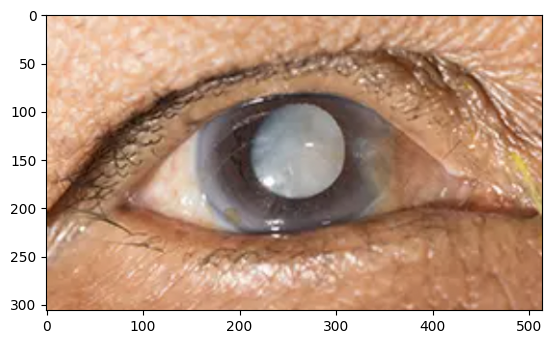

In [56]:
image = cv2.imread('./cataract 2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [57]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((300, 300)),
])

image = test_transforms(image)
image = torch.reshape(image, (1, 3, 300, 300))

In [58]:
model.eval()
pred2label[np.argmax(model(image).cpu().detach().numpy())]

'cataract'